In [17]:
#Step 1 – Import required libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from collections import Counter
import heapq
import math


In [19]:
#Step 2 – Define DCT / IDCT and Zig-Zag utilities
# 2D DCT and IDCT
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Zig-zag scan order
def zigzag(block):
    rows, cols = block.shape
    solution = [[] for _ in range(rows + cols - 1)]
    for i in range(rows):
        for j in range(cols):
            s = i + j
            if s % 2 == 0:
                solution[s].insert(0, block[i][j])
            else:
                solution[s].append(block[i][j])
    return [item for sublist in solution for item in sublist]

def inverse_zigzag(arr, rows=8, cols=8):
    solution = np.zeros((rows, cols))
    index = 0
    for s in range(rows + cols - 1):
        if s % 2 == 0:
            for i in range(s, -1, -1):
                j = s - i
                if i < rows and j < cols:
                    solution[i][j] = arr[index]
                    index += 1
        else:
            for j in range(s, -1, -1):
                i = s - j
                if i < rows and j < cols:
                    solution[i][j] = arr[index]
                    index += 1
    return solution


In [21]:
#Step 3 – Quantization matrix and quality-factor scaling
Q50 = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
])

def scale_quant_matrix(Q):
    if Q < 50 and Q > 1:
        S = 5000 / Q
    elif Q < 100:
        S = 200 - 2 * Q
    else:
        S = 1
    return np.floor((Q50 * S + 50) / 100)


In [7]:
#Step 4 – Huffman coding utilities
class Node:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def huffman_encoding(data):
    freq = Counter(data)
    heap = [Node(symbol, freq) for symbol, freq in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = Node(None, node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    root = heap[0]
    codes = {}
    def generate_codes(node, current_code=""):
        if node is None: return
        if node.symbol is not None:
            codes[node.symbol] = current_code
            return
        generate_codes(node.left, current_code + "0")
        generate_codes(node.right, current_code + "1")
    generate_codes(root)
    encoded_data = ''.join([codes[sym] for sym in data])
    return encoded_data, codes

def huffman_decoding(encoded_data, codes):
    reverse_codes = {v: k for k, v in codes.items()}
    current = ""
    decoded = []
    for bit in encoded_data:
        current += bit
        if current in reverse_codes:
            decoded.append(reverse_codes[current])
            current = ""
    return decoded


In [23]:
#Step 5 – Compression and decompression functions
def compress_image(img, Q=50):
    img = np.array(img, dtype=np.float32)
    h, w = img.shape
    padded_h = int(np.ceil(h / 8)) * 8
    padded_w = int(np.ceil(w / 8)) * 8
    padded = np.zeros((padded_h, padded_w))
    padded[:h, :w] = img
    padded -= 128

    q_matrix = scale_quant_matrix(Q)
    symbols = []
    for i in range(0, padded_h, 8):
        for j in range(0, padded_w, 8):
            block = padded[i:i+8, j:j+8]
            dct_block = dct2(block)
            quant_block = np.round(dct_block / q_matrix)
            zz = zigzag(quant_block)
            symbols.extend(zz)
    encoded_data, codes = huffman_encoding(symbols)
    return encoded_data, codes, (h, w), padded_h, padded_w, q_matrix

def decompress_image(encoded_data, codes, shape, padded_h, padded_w, q_matrix):
    symbols = huffman_decoding(encoded_data, codes)
    blocks = [symbols[i:i+64] for i in range(0, len(symbols), 64)]
    recon = np.zeros((padded_h, padded_w))
    idx = 0
    for i in range(0, padded_h, 8):
        for j in range(0, padded_w, 8):
            block = np.array(blocks[idx])
            idx += 1
            block = inverse_zigzag(block)
            block = block * q_matrix
            recon[i:i+8, j:j+8] = idct2(block)
    recon = recon[:shape[0], :shape[1]] + 128
    recon = np.clip(recon, 0, 255)
    return recon.astype(np.uint8)


In [11]:
#Step 6 – Compute metrics
def compute_metrics(original, reconstructed, encoded_data):
    orig_size_bits = original.size * 8
    comp_size_bits = len(encoded_data)
    cr = orig_size_bits / comp_size_bits
    bpp = comp_size_bits / original.size
    psnr_val = psnr(original, reconstructed)
    ssim_val = ssim(original, reconstructed)
    return cr, bpp, psnr_val, ssim_val


In [13]:
#Step 7 – Run for multiple quality factors
image = Image.open("lena.jpg").convert("L")
original = np.array(image)
qualities = [90, 70, 50, 30, 10]
results = []
reconstructed_images = []

for Q in qualities:
    encoded, codes, shape, ph, pw, qmat = compress_image(image, Q)
    recon = decompress_image(encoded, codes, shape, ph, pw, qmat)
    reconstructed_images.append(recon)
    cr, bpp_val, psnr_val, ssim_val = compute_metrics(original, recon, encoded)
    results.append((Q, cr, bpp_val, psnr_val, ssim_val))

import pandas as pd
df = pd.DataFrame(results, columns=["Quality", "Compression Ratio", "bpp", "PSNR", "SSIM"])
df


,Quality,Compression Ratio,bpp,PSNR,SSIM
0,90,3.251262,2.460583,47.162883,0.995466
1,70,4.798755,1.667099,37.077547,0.944463
2,50,5.531339,1.446304,35.498634,0.924374
3,30,6.127329,1.305626,34.012176,0.901296
4,10,7.103572,1.126194,30.245138,0.817959


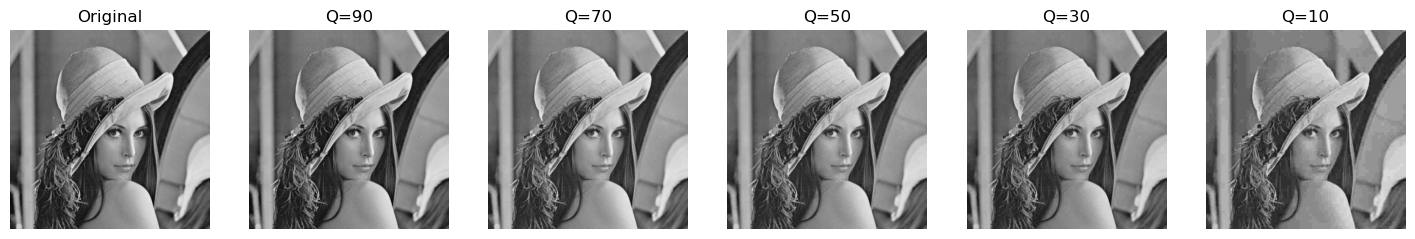

Compression Results:


,Quality,Compression Ratio,bpp,PSNR,SSIM
0,90,3.251262,2.460583,47.162883,0.995466
1,70,4.798755,1.667099,37.077547,0.944463
2,50,5.531339,1.446304,35.498634,0.924374
3,30,6.127329,1.305626,34.012176,0.901296
4,10,7.103572,1.126194,30.245138,0.817959


In [15]:
fig, axes = plt.subplots(1, 6, figsize=(18, 5))
axes[0].imshow(original, cmap='gray')
axes[0].set_title("Original")

for idx, (Q, img) in enumerate(zip(qualities, reconstructed_images)):
    axes[idx+1].imshow(img, cmap='gray')
    axes[idx+1].set_title(f"Q={Q}")

for ax in axes:
    ax.axis("off")
plt.show()

print("Compression Results:")
display(df)
